# Human Pose Classification - Using Vision Transformers


In [1]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [4]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/Human_Action_Recognition", split='train')



README.md:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/98.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5400 [00:00<?, ? examples/s]

In [5]:
dataset = dataset.shuffle().train_test_split(test_size=0.2)

In [6]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=275x183>,
 'labels': 5}

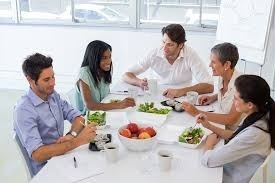

In [7]:
dataset['train'][0]['image']


In [8]:
labels = dataset['train'].features['labels'].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)


{'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14}
{0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}


# Image Preprocessing

In [9]:
from transformers import AutoImageProcessor #-> like Tokenizer

model_ckpt = "google/vit-base-patch16-224-in21k"
# model_ckpt = "microsoft/swinv2-tiny-patch4-window16-256"


In [11]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (image_processor.size['shortest_edge'] if 'shortest_edge' in image_processor.size
        else (image_processor.size['height'], image_processor.size['width']))

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(batch):
    batch['pixel_values'] = [_transforms(img.convert('RGB')) for img in batch['image']]

    del batch['image']

    return batch



preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [12]:
dataset = dataset.with_transform(transforms)


# Evaluate the Model

In [14]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00


In [15]:
# !pip install evaluate

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


# Vision Transformers (ViT) Fine Tuning for Image Classification

In [16]:
from transformers import AutoModelForImageClassification
import torch


In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id
).to(device)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
len(labels)


15

# Model Training

In [21]:
from transformers import TrainingArguments, Trainer


args = TrainingArguments(
    output_dir="train_dir",
    remove_unused_columns=False,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)


trainer = Trainer(
    model = model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)


In [22]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,1.331000,1.259241,0.728175


TrainOutput(global_step=630, training_loss=1.312625000968812, metrics={'train_runtime': 390.3655, 'train_samples_per_second': 25.822, 'train_steps_per_second': 1.614, 'total_flos': 7.81210267337687e+17, 'train_loss': 1.312625000968812, 'epoch': 1.0})

In [ ]:
5299a845f1a7e00ffeccd60dc01592cbd14918a6

In [23]:
trainer.evaluate()


{'eval_loss': 1.2413196563720703,
 'eval_accuracy': 0.734920634920635,
 'eval_runtime': 32.4948,
 'eval_samples_per_second': 77.551,
 'eval_steps_per_second': 4.862,
 'epoch': 1.0}

In [ ]:
trainer.save_model('vit-human-pose-classification')


In [1]:
# upload model folder to s3 bucket ml-models/vit-human-pose-classification
import os
import boto3

s3 = boto3.client('s3')
bucket_name = 'mlops-44448888'

def upload_directory(directory_path, s3_prefix):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file).replace("\\", "/")
            relpath = os.path.relpath(file_path, directory_path)
            s3_key = os.path.join(s3_prefix, relpath).replace("\\", "/")
            
            s3.upload_file(file_path, bucket_name, s3_key)


upload_directory('vit-human-pose-classification', 'ml-models/vit-human-pose-classification')

